### Libraries

In [ ]:
import geopandas as gpd
import pandas as pd
from timeit import timeit
from tkinter import NE
import pytest
import multiprocessing 
import numpy as np
from multiprocessing import Pool
import random
from functools import reduce
import time
from shapely.geometry import Point, Polygon
from sentinelhub import *
import os
import json
from functools import wraps
import pytest
import unittest
from unittest import mock
from unittest.mock import patch
from faker import Faker
import datetime as dt
import matplotlib.pyplot as plt
import re
import shutil, tempfile
from os import path
import unittest
import inspect
import matplotlib.pyplot as plt
from skopt.space import Space
from skopt.sampler import Sobol
from skopt.sampler import Lhs
from skopt.sampler import Halton
from skopt.sampler import Hammersly
from skopt.sampler import Grid
from scipy.spatial.distance import pdist

First, we read the dataframe that we would be using for sampling

In [ ]:
gdf=gpd.read_file("/home/ahnaf.ryan/data_download/SaskGrid_2015_QUARTERSECTION/SaskGrid_2015_QUARTERSECTION.shp")

We are removing the rows with None values

In [ ]:
gdf=gdf.head(-2)

Let us first calculate the population attributes

### Population Attributes

In [95]:
def pop_attributes(df):
    featurecd=df['FEATURECD'].value_counts(normalize=True) * 100
    qsect=df['QSECT'].value_counts(normalize=True) * 100
    pmer=df['PMER'].value_counts(normalize=True) * 100
    psect=df["PSECT"].value_counts(normalize=True)*100
    ptwp=df["PTWP"].value_counts(normalize=True)*100
    prge=df["PRGE"].value_counts(normalize=True)*100
    return featurecd,qsect,pmer,psect,ptwp,prge
pop_at=pop_attributes(gdf)

Let us start by plotting some of the distribution of our attributes

Text(0.5, 1.0, 'Normalized Percentage of FEATURECD')

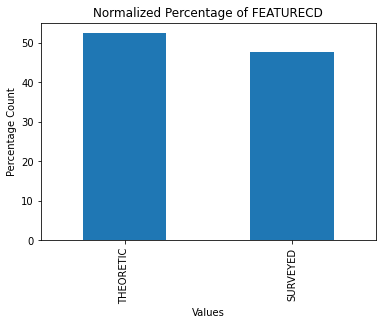

In [96]:
pop_at[0].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of FEATURECD")

We can see that the featurecd attribute has even distribution with almost ratio of 1:1. Now, let us see the distribution of qsect

Text(0.5, 1.0, 'Normalized Percentage of QSECT')

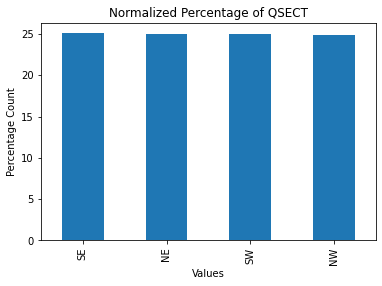

In [97]:
pop_at[1].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of QSECT")

Similar to featurecd, qsect values are evenly distributed. Now, let us look into the distribution of PMER

Text(0.5, 1.0, 'Normalized Percentage of PMER')

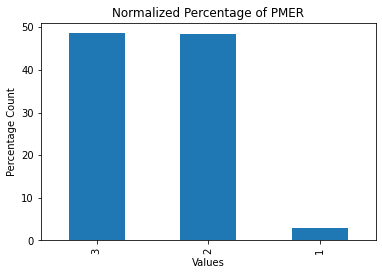

In [98]:
pop_at[2].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PMER")

Here, we can see that 1 and 2 values are evenly distributed while 1 does not appear that much in the population

Text(0.5, 1.0, 'Normalized Percentage of PSECT')

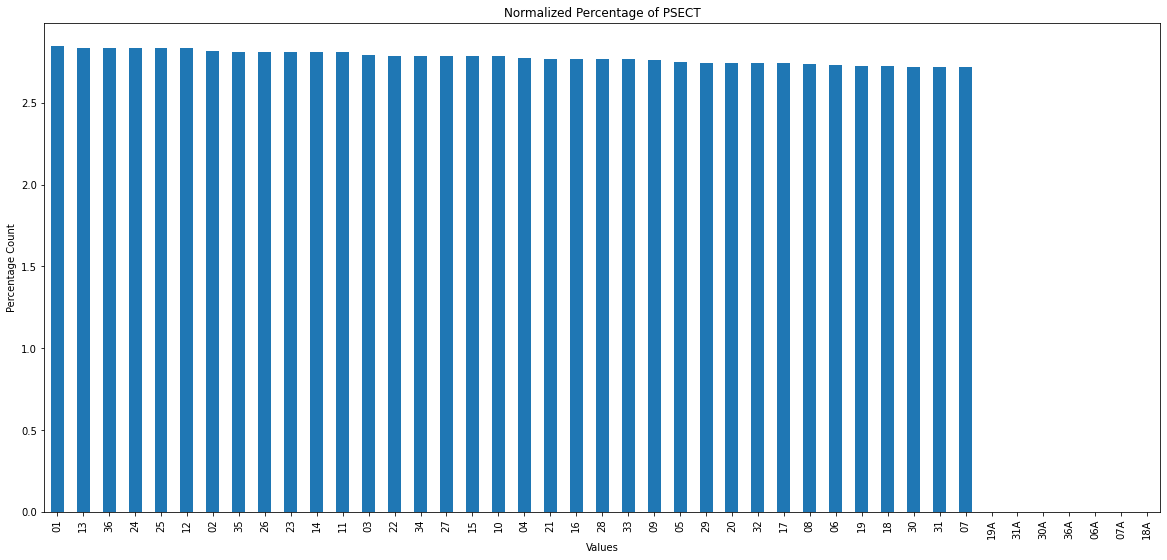

In [99]:
fig, ax = plt.subplots(figsize =(20, 9))
pop_at[3].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PSECT")

PSECT distribution is an interesting observation with most values having even distribution but few values occur in negligible scale

Text(0.5, 1.0, 'Normalized Percentage of PTWP')

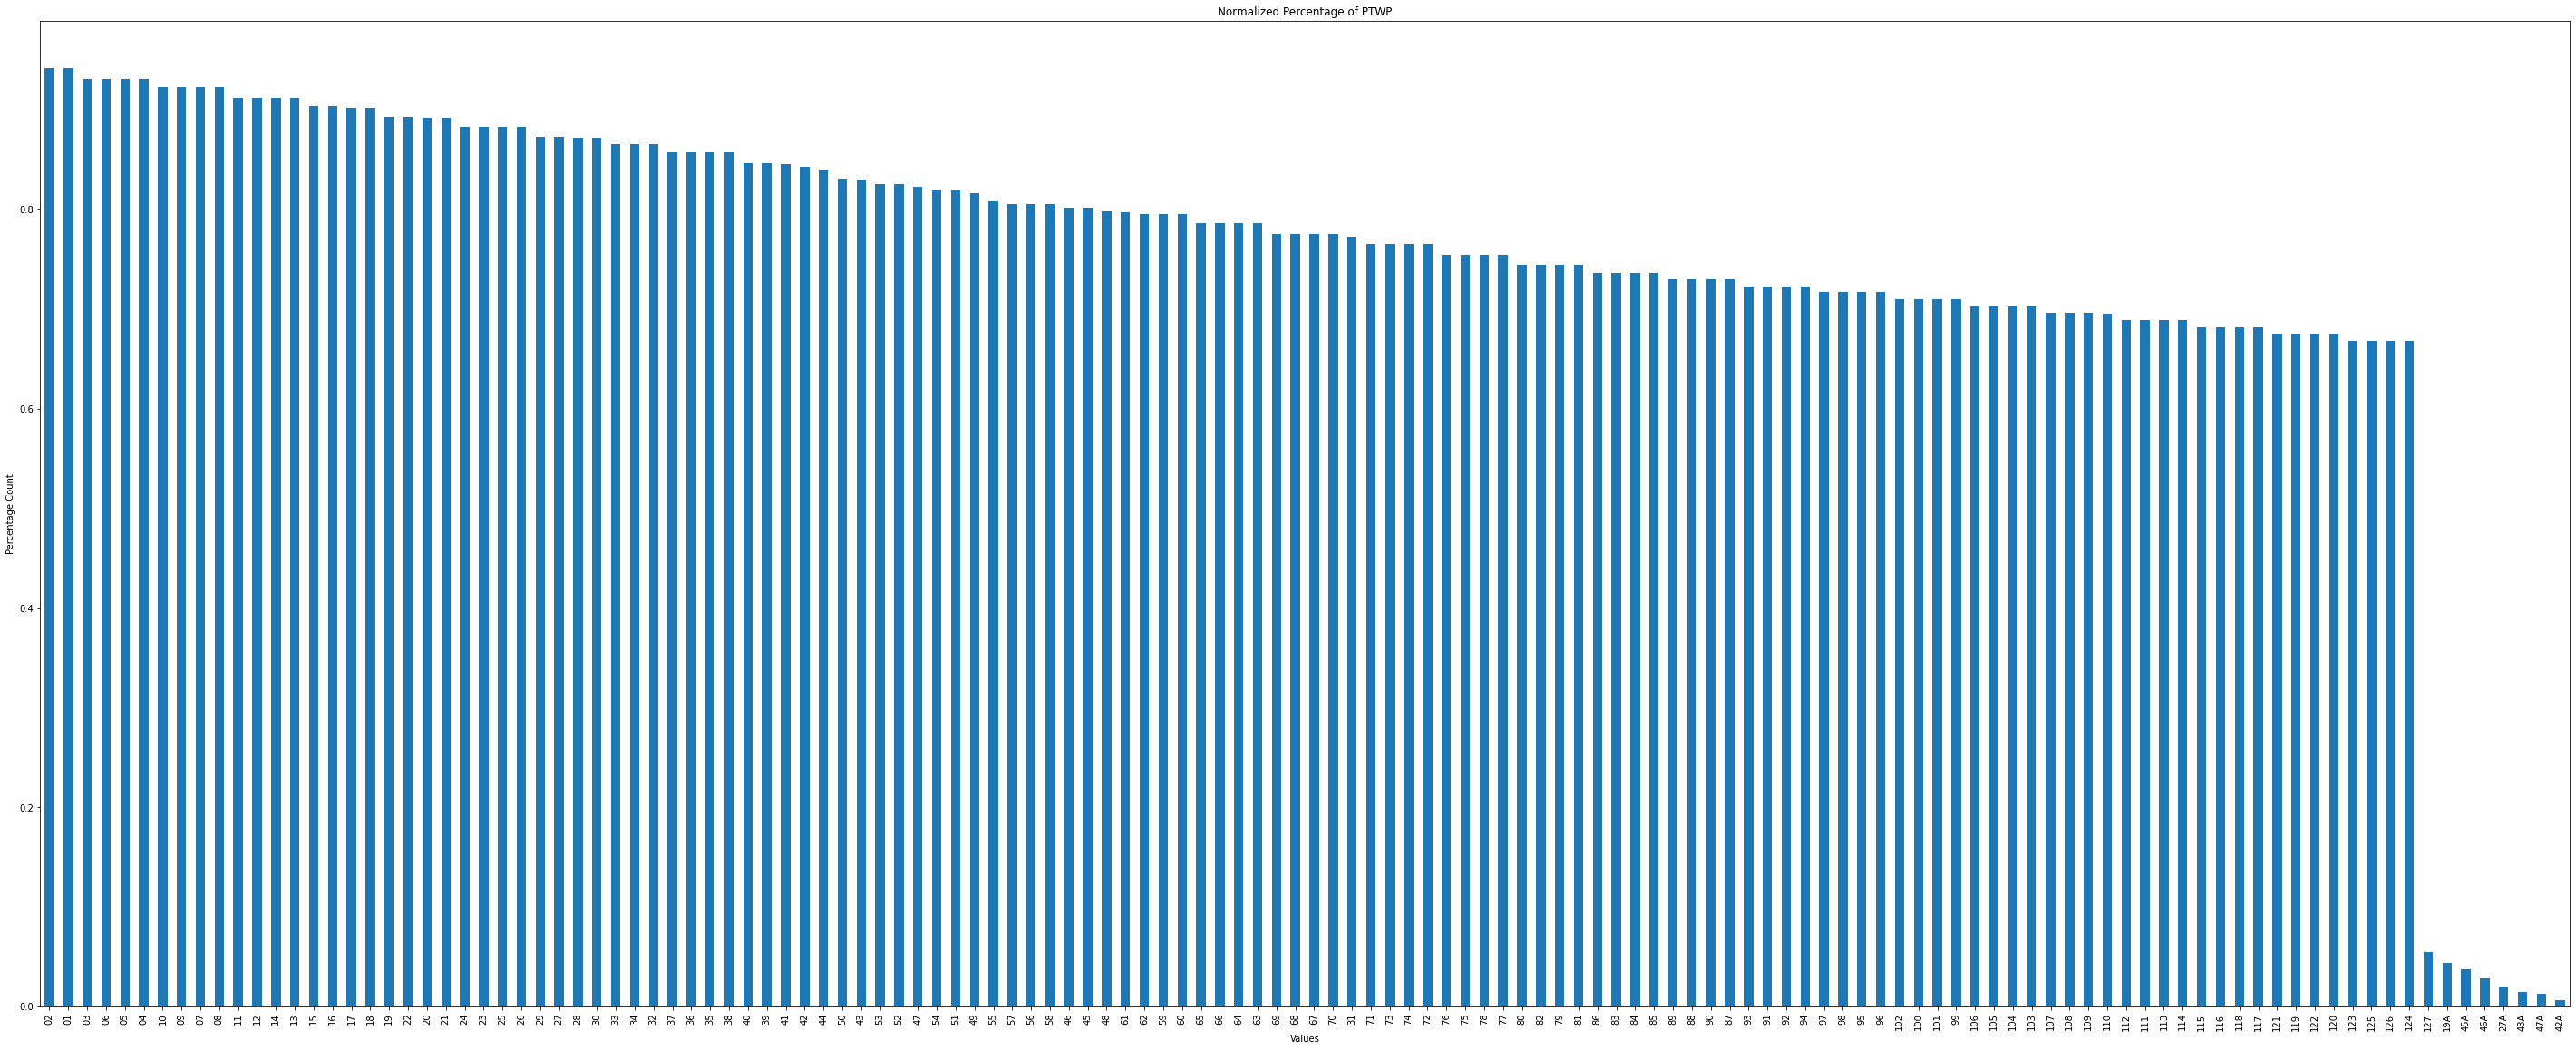

In [100]:
fig, ax = plt.subplots(figsize =(50, 20))
pop_at[4].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PTWP")

The distribution of values slightly decreases as we go from left to right values in other words as values are increased, we see percentage to fall

Text(0.5, 1.0, 'Normalized Percentage of PRGE')

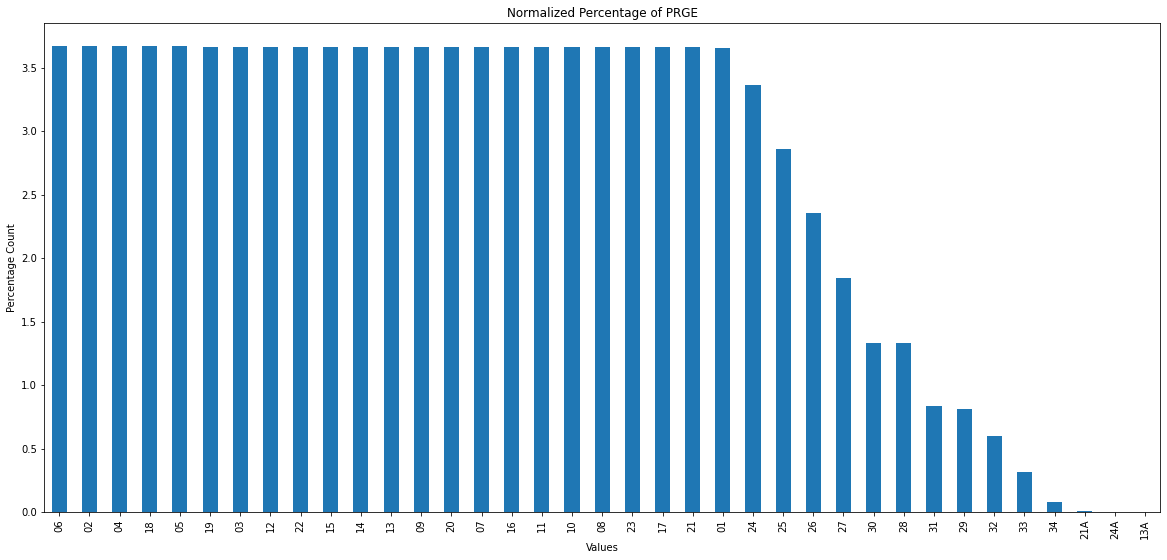

In [101]:
fig, ax = plt.subplots(figsize =(20, 9))
pop_at[5].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE")

PRGE has similar tendencies as PSECT

### Different Types of Sampling Techniques

Ideally, we would like our sample to follow similar distribution so we start by trying different sampling techniques

We first start with random sampling with replacement

#### 1) Random Sampling without Replacement

In [102]:
def random_sampling_rep(gdf):
    return gdf.sample(n=10000,replace=False)
samp_nrep_at=pop_attributes(random_sampling_rep(gdf))

Text(0.5, 1.0, 'Normalized Percentage of FEATURECD for Sampling without Replacement')

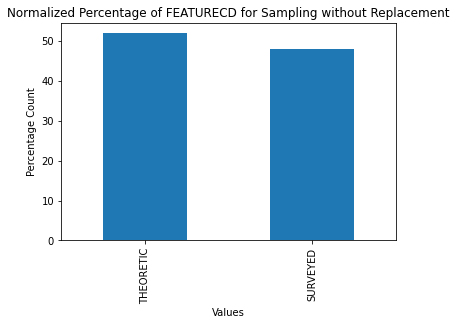

In [106]:
samp_nrep_at[0].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of FEATURECD for Sampling without Replacement")

Random Sampling without replacement did a good job in sampling featurecd values since it looks similar to the population.

Text(0.5, 1.0, 'Normalized Percentage of QSECT for Sampling without Replacement')

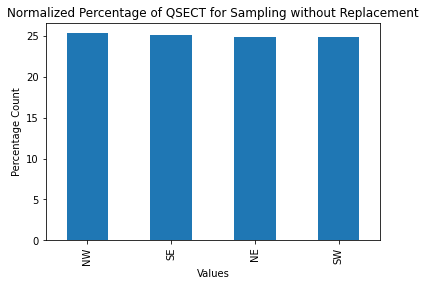

In [107]:
samp_nrep_at[1].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of QSECT for Sampling without Replacement")

Again, it looks very similar to the population. We now repeat for the other attributes and try to quantify the absolute error

Text(0.5, 1.0, 'Normalized Percentage of PMER for Sampling without Replacement')

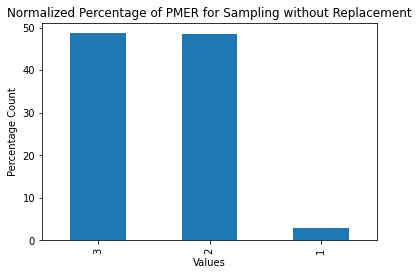

In [108]:
samp_nrep_at[2].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PMER for Sampling without Replacement")

Text(0.5, 1.0, 'Normalized Percentage of PSECT for Sampling without Replacement')

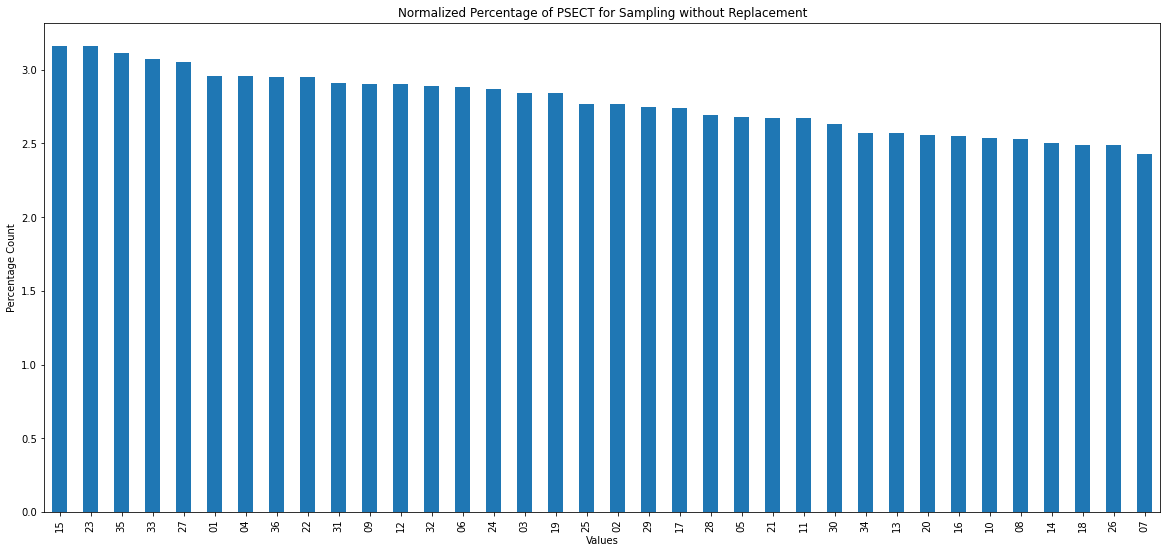

In [138]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_nrep_at[3].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PSECT for Sampling without Replacement")

It does a decent job in understanding the distribution of PSECT

Our sample do not capture the outliers at all from the population for PSECT which is expected

Text(0.5, 1.0, 'Normalized Percentage of PTWP for Sampling without replacement')

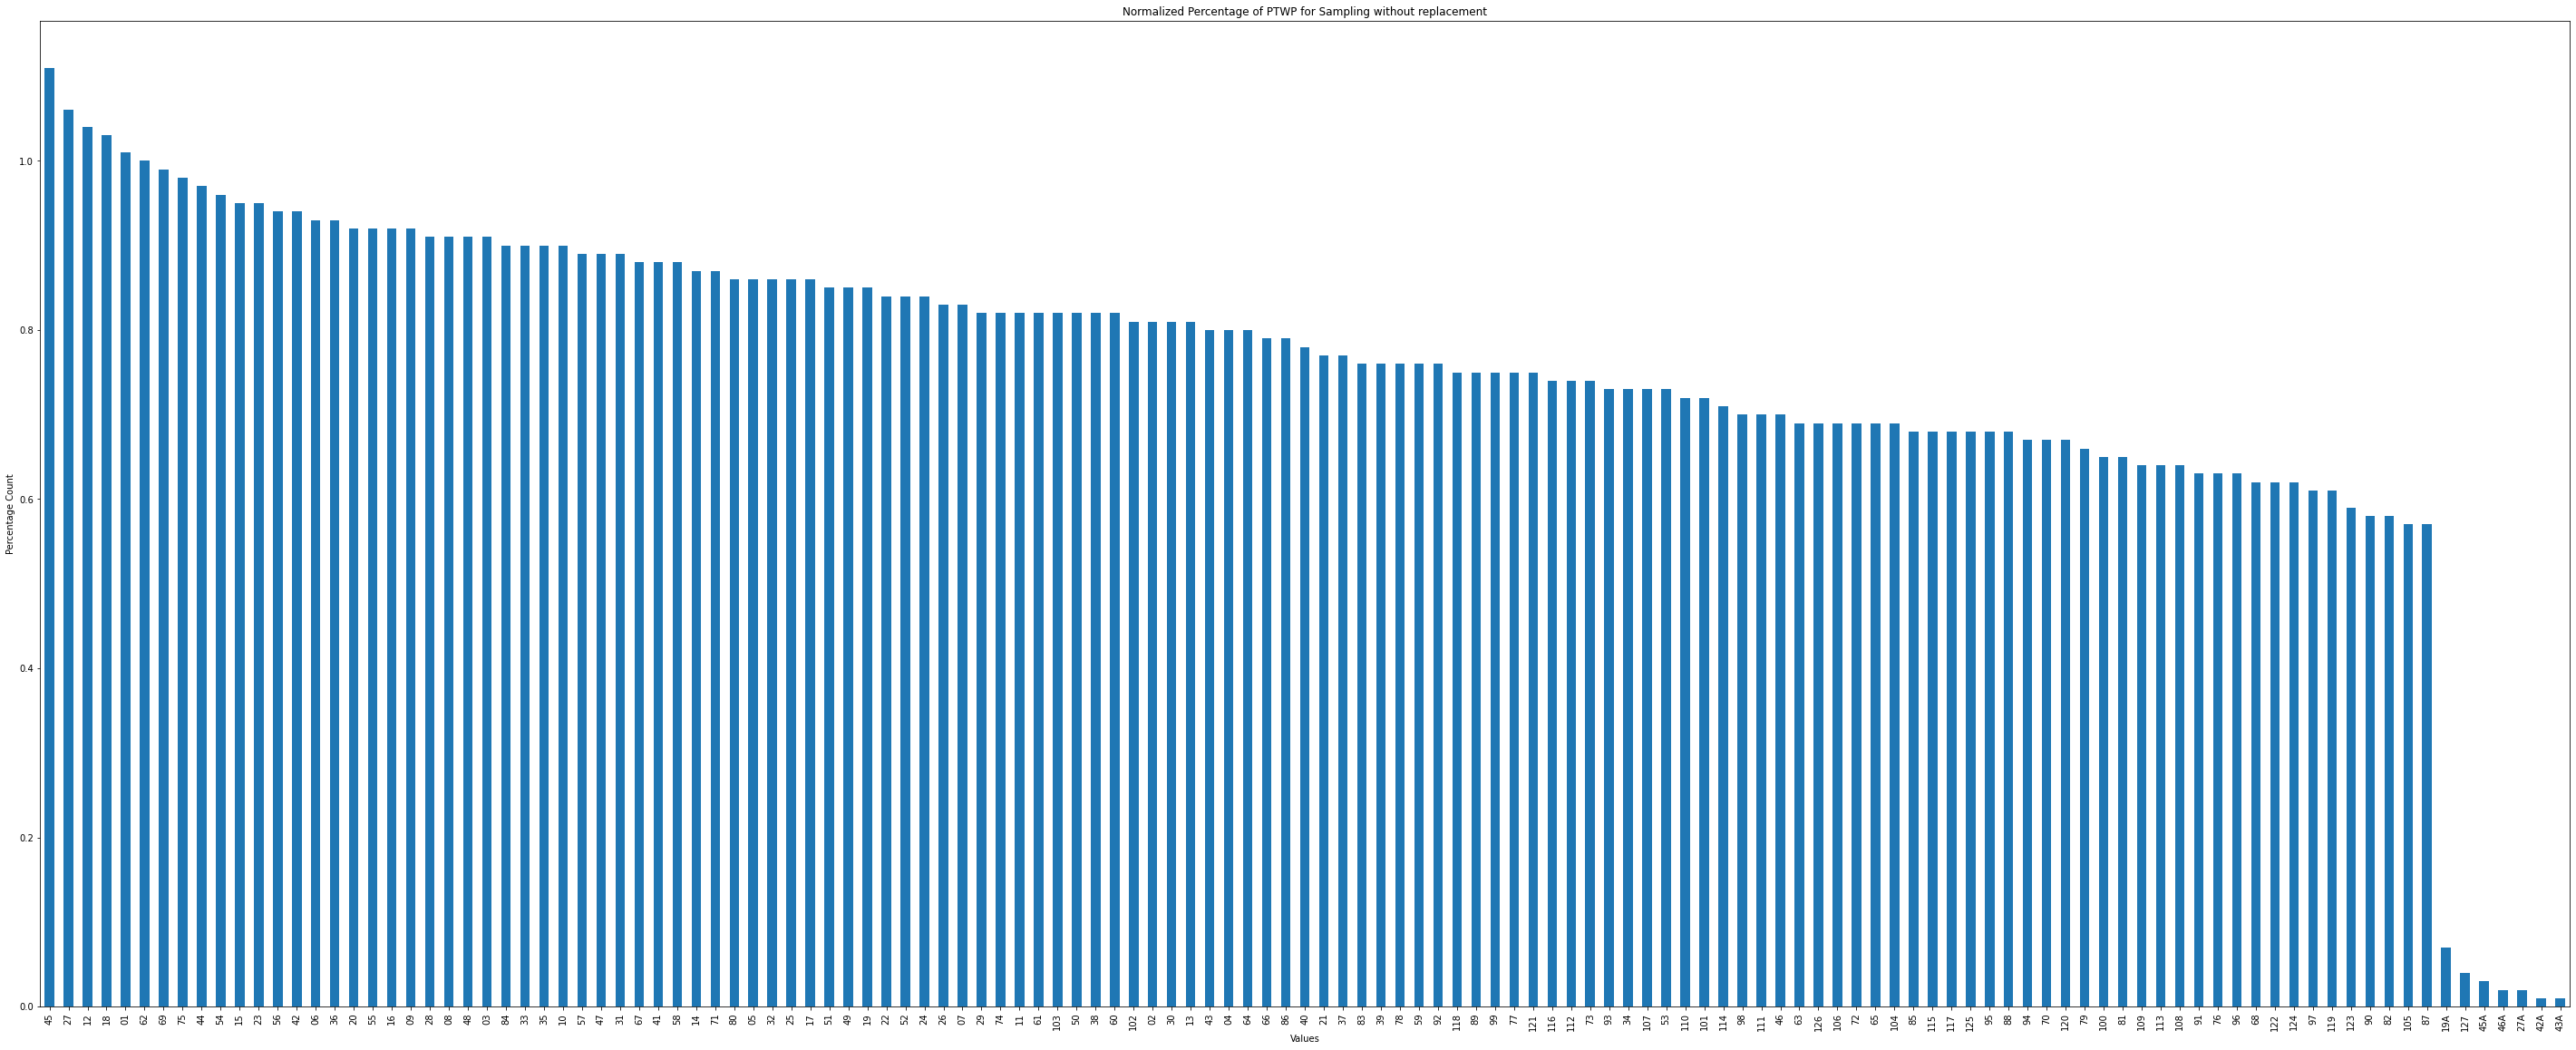

In [112]:
fig, ax = plt.subplots(figsize =(50, 20))
samp_nrep_at[4].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PTWP for Sampling without replacement")

This is astonshingly similar to the population

Text(0.5, 1.0, 'Normalized Percentage of PRGE for sampling without replacement')

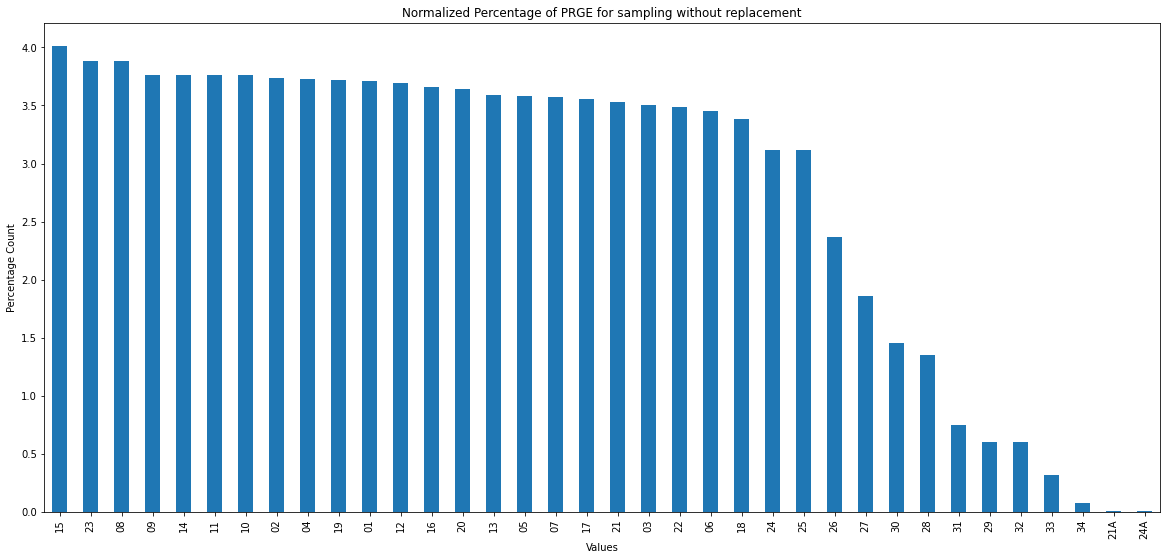

In [114]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_nrep_at[5].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE for sampling without replacement")

PRGE is also quite good in this sampling technique

Let us calculate the sample errors for Random Sampling without Replacement

In [ ]:
def samp_error(pop_at,samp_at):
    samp_featurecd_error=np.sum(abs(pop_at[0]-samp_at[0]))
    samp_qsect_error=np.sum(abs(pop_at[1]-samp_at[1]))
    samp_pmer_error=np.sum(abs(pop_at[2]-samp_at[2]))
    samp_psect_error=np.sum(abs(pop_at[3]-samp_at[3]))
    samp_ptwp_error=np.sum(abs(pop_at[4]-samp_at[4]))
    samp_prge_error=np.sum(abs(pop_at[5]-samp_at[5]))
    return samp_featurecd_error,samp_qsect_error,samp_pmer_error,samp_psect_error,samp_ptwp_error,samp_prge_error
    

In [ ]:
error_samp_nrep=samp_error(pop_at,samp_nrep_at)

These are absolute sample errors for our attributes for Random Sampling without replacement. Now let us move to random sampling with replacement

#### Sampling with Replacement

In [115]:
def random_sampling_rep(gdf):
    return gdf.sample(n=10000,replace=True)
samp_rep_at=pop_attributes(random_sampling_rep(gdf))

Text(0.5, 1.0, 'Normalized Percentage of FEATURECD for Sampling with Replacement')

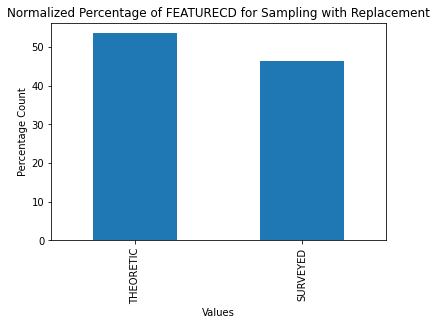

In [120]:
samp_rep_at[0].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of FEATURECD for Sampling with Replacement")

Sampling with Replacement also does a good job in sampling Featurecd values but not as good as sampling without replacement

Text(0.5, 1.0, 'Normalized Percentage of QSECT for Sampling with Replacement')

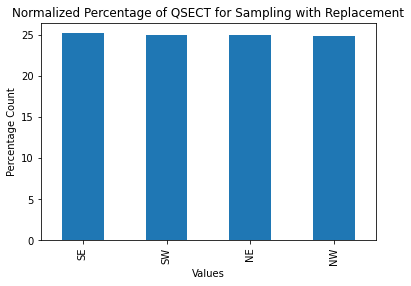

In [121]:
samp_rep_at[1].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of QSECT for Sampling with Replacement")

It does a good job in QSECT as it is similar to the population

Text(0.5, 1.0, 'Normalized Percentage of PMER for Sampling without Replacement')

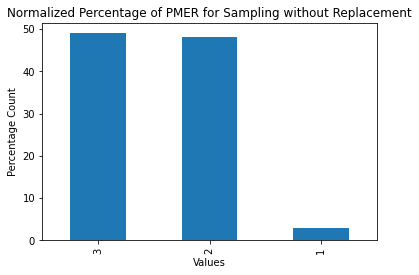

In [122]:
samp_rep_at[2].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PMER for Sampling with Replacement")

Text(0.5, 1.0, 'Normalized Percentage of PSECT for Sampling with Replacement')

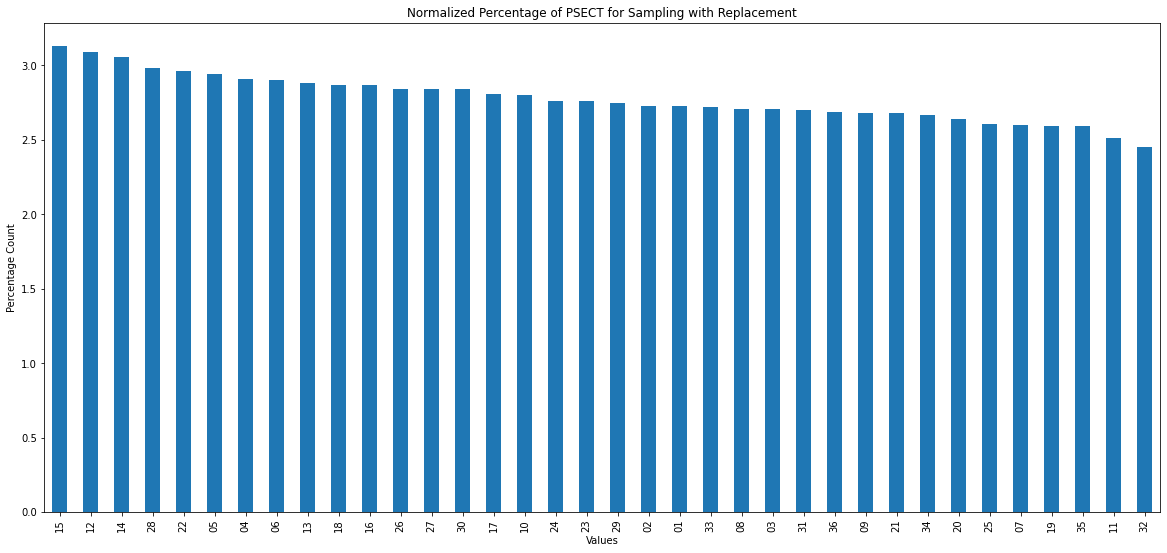

In [123]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_rep_at[3].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PSECT for Sampling with Replacement")

Text(0.5, 1.0, 'Normalized Percentage of PTWP for Sampling with replacement')

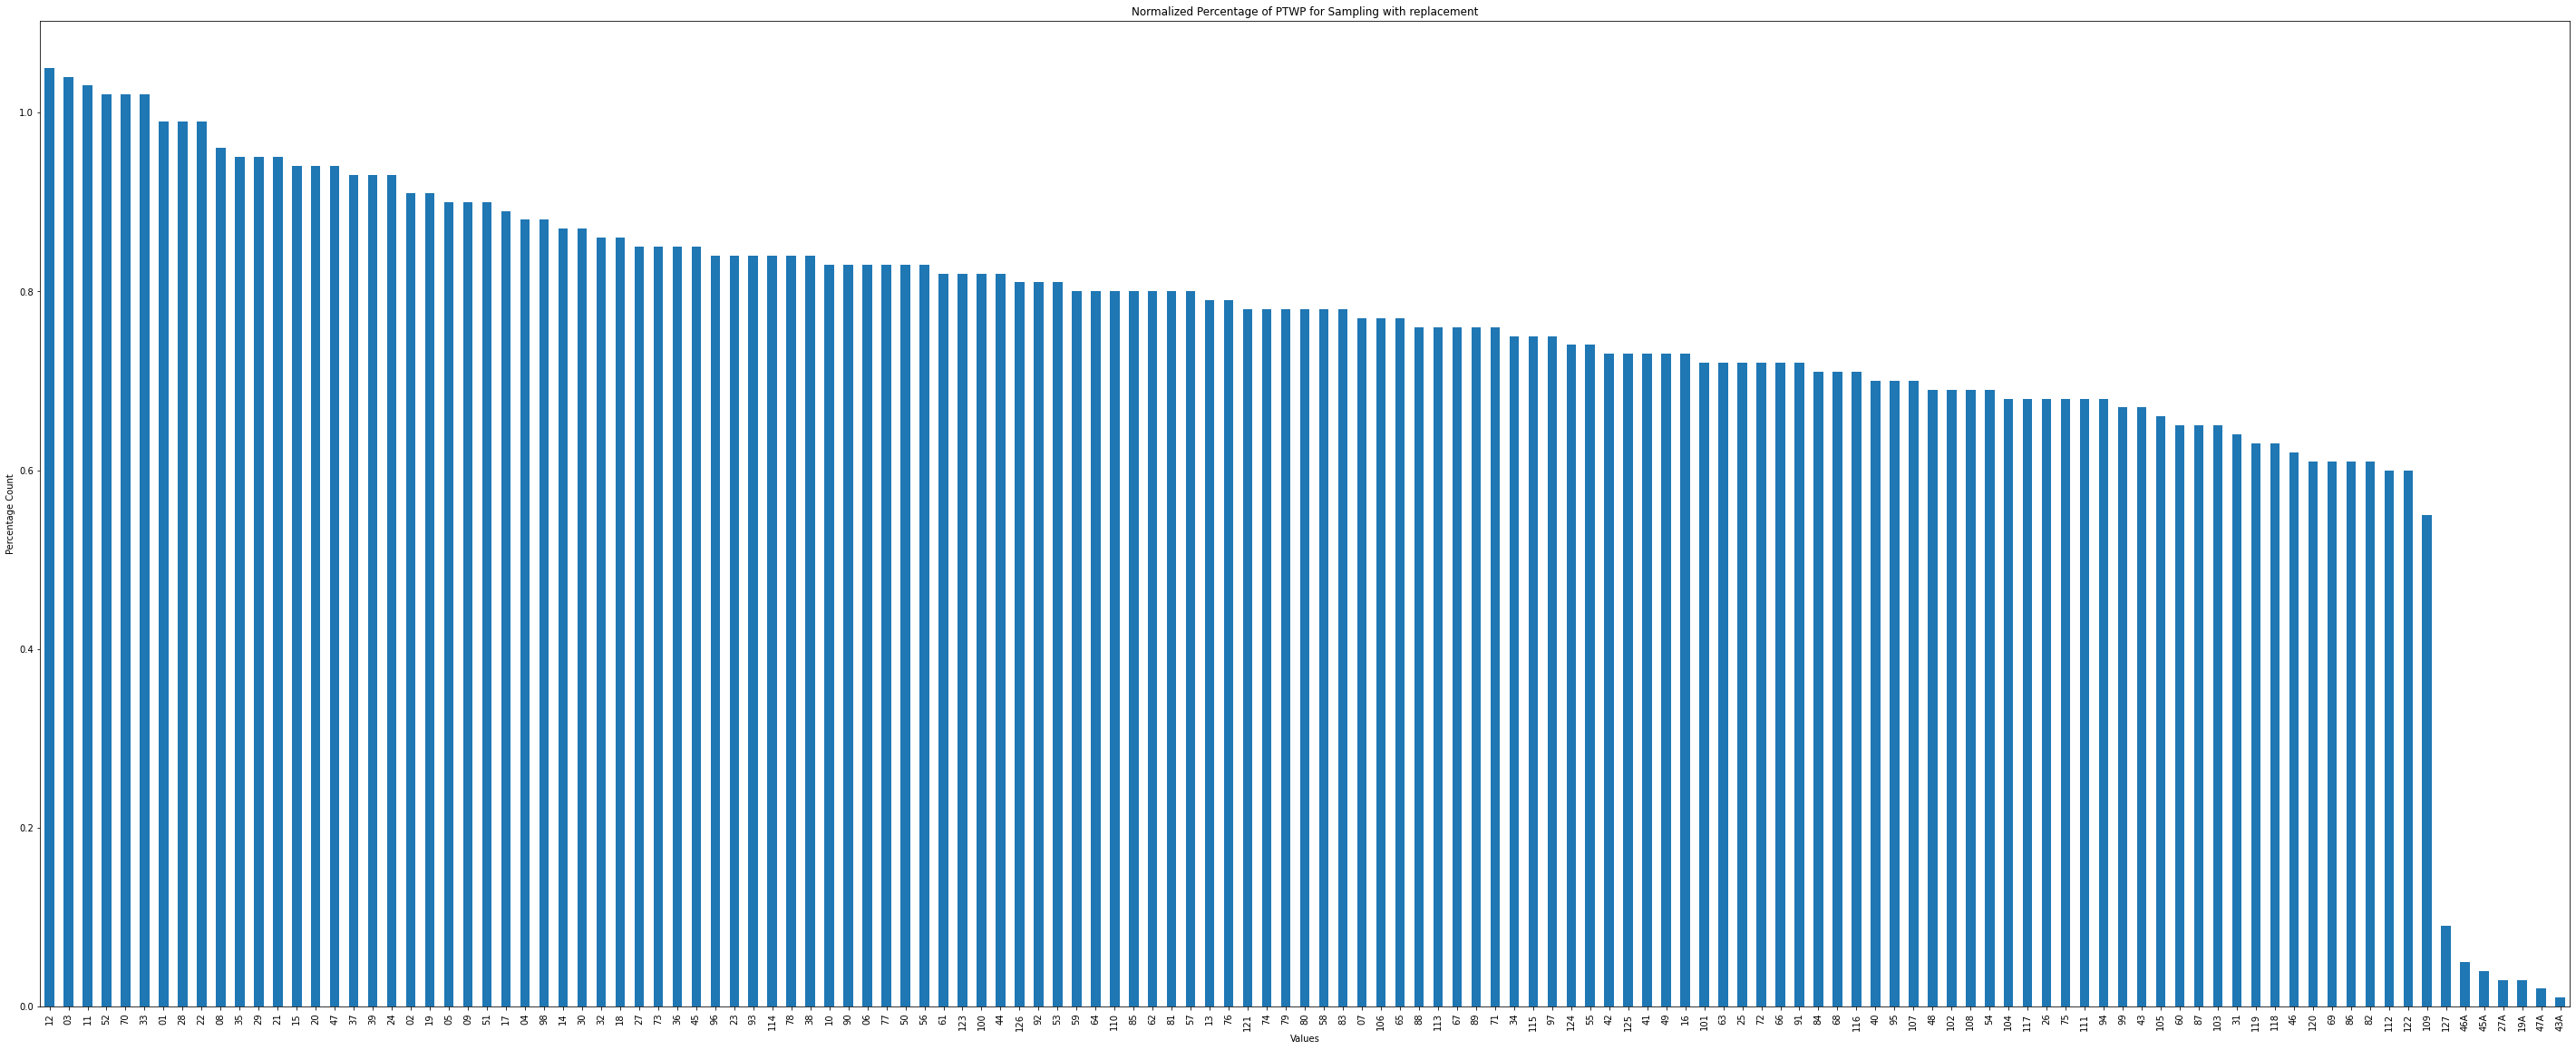

In [124]:
fig, ax = plt.subplots(figsize =(50, 20))
samp_rep_at[4].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PTWP for Sampling with replacement")

Text(0.5, 1.0, 'Normalized Percentage of PRGE for sampling with replacement')

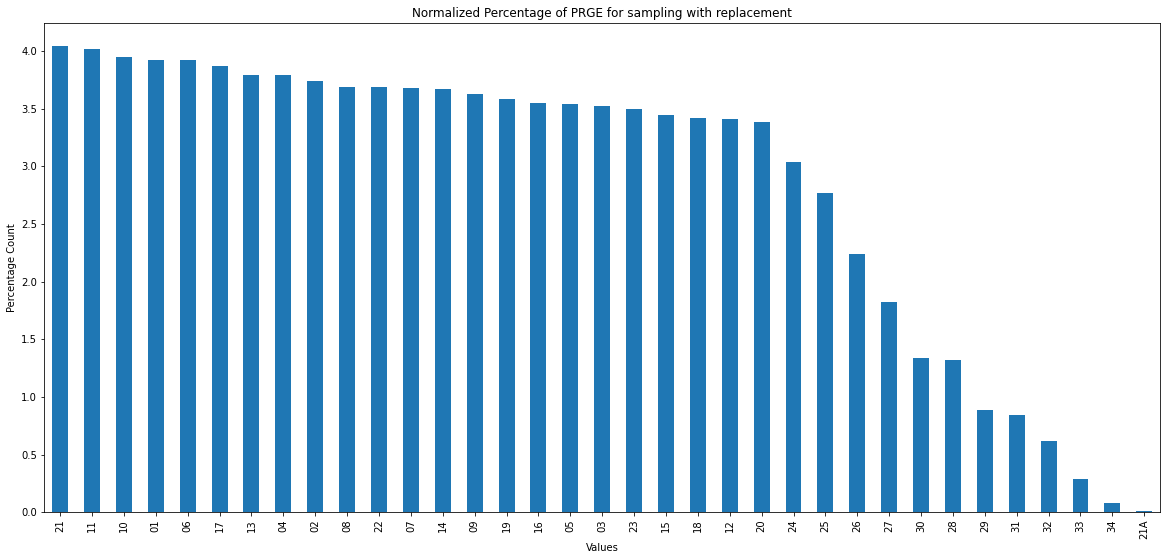

In [125]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_rep_at[5].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE for sampling with replacement")

Overall, we can see that sampling with replacement did a good job but not as good as sampling without replacement

In [126]:
error_samp_rep=samp_error(pop_at,samp_rep_at)

These are the absolute sample errors for sampling with Replacement. Let us move to stratified sampling now.

#### Sampling with Stratification

In [ ]:
def stratified_sampling(gdf,col):
    grouped_df=gdf.groupby(col)
    df=gdf.head(0)
    for key,item in grouped_df:
        a_group=grouped_df.get_group(key)
        ratio=len(a_group)/len(gdf)
        samp=a_group.sample(n=round(ratio*10000))
        df=pd.concat([df,samp])
    return df    

samp_st_at=pop_attributes(stratified_sampling(gdf,gdf.QSECT))

Text(0.5, 1.0, 'Normalized Percentage of FEATURECD')

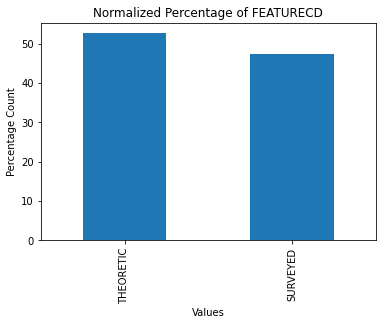

In [127]:
samp_st_at[0].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of FEATURECD for sampling with stratification")

Sampling with strafication does a great job in featurecd

Text(0.5, 1.0, 'Normalized Percentage of QSECT for sampling with stratification')

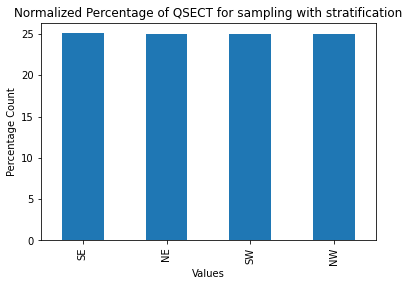

In [130]:
samp_st_at[1].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of QSECT for sampling with stratification")

As expected, it does an excellent job since stratification was done on QSECT

Text(0.5, 1.0, 'Normalized Percentage of PMER for sampling with stratification')

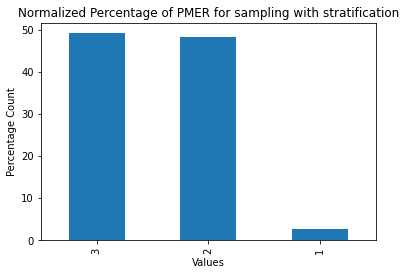

In [131]:
samp_st_at[2].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PMER for sampling with stratification")

It does a great job on PMER

Text(0.5, 1.0, 'Normalized Percentage of PSECT for sampling with Stratification')

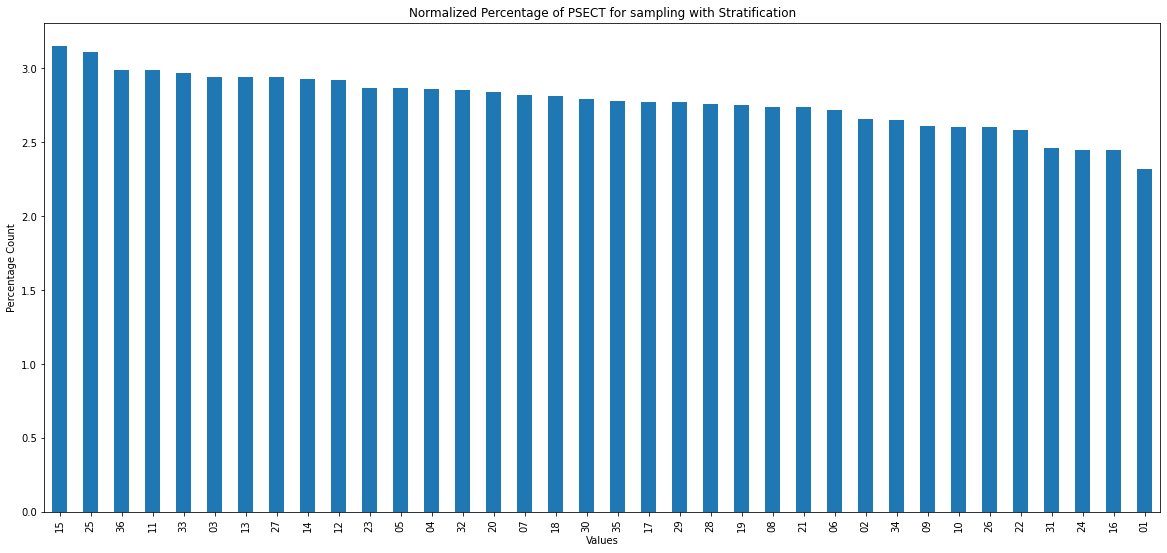

In [134]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_st_at[3].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PSECT for sampling with Stratification")

Stratification does not do a good job for PSECT since we can see 01 values appear the least when they appear the most

Text(0.5, 1.0, 'Normalized Percentage of PTWP')

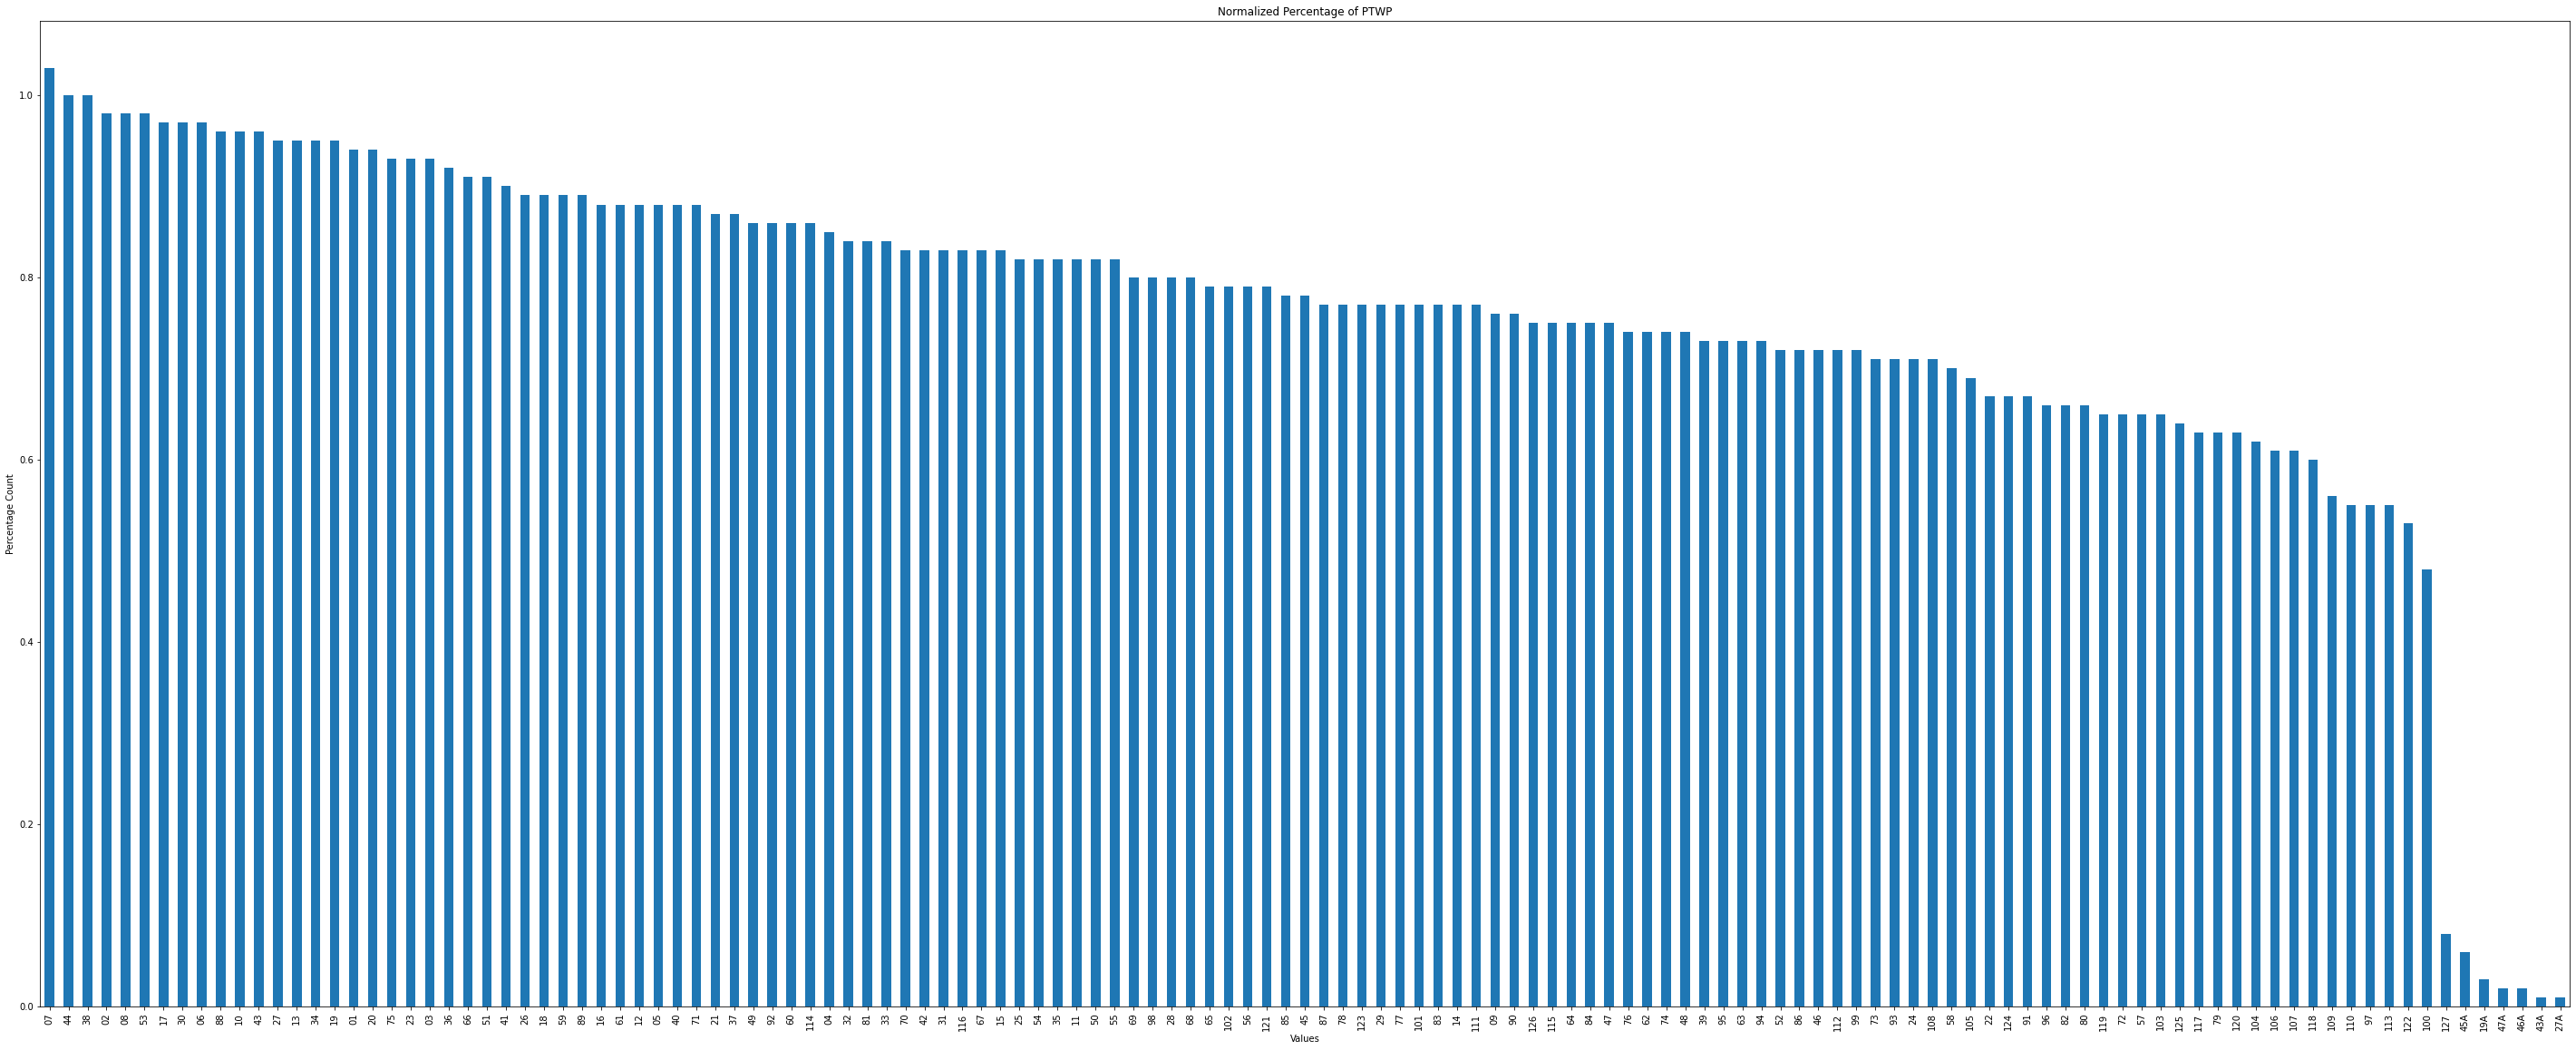

In [135]:
fig, ax = plt.subplots(figsize =(50, 20))
samp_st_at[4].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PTWP for sampling with Stratification")

Text(0.5, 1.0, 'Normalized Percentage of PRGE for sampling with Stratification')

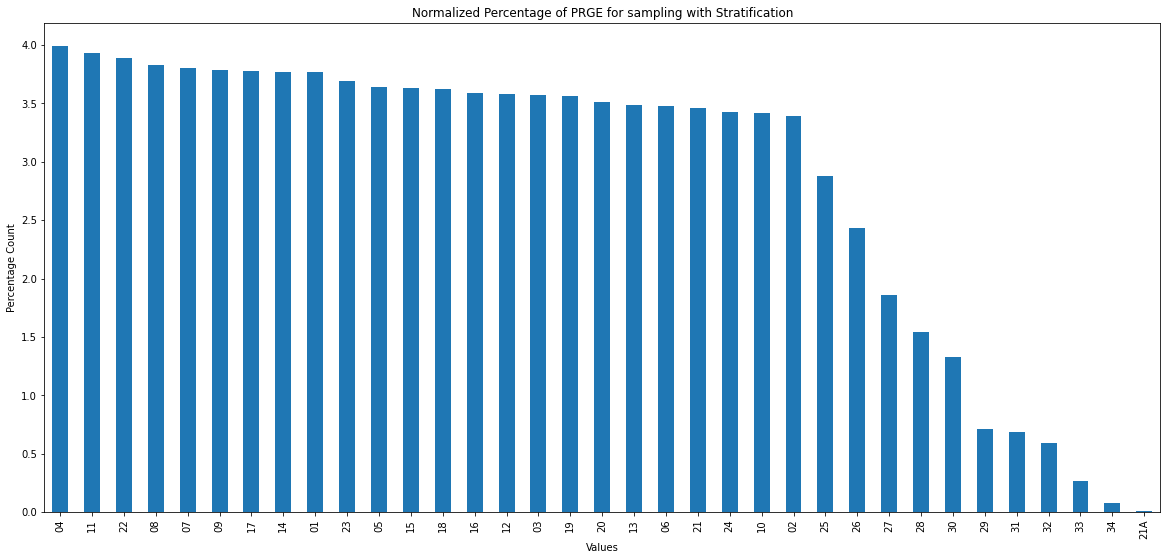

In [136]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_st_at[5].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE for sampling with Stratification")

it does a good job for PRGE

In [137]:
samp_error_str=samp_error(pop_at,samp_st_at)

These are the absolute sample errors stratified sampling.Now, let us move to a different sampling technique where we divide the dataframe into

#### Sampling with Custom Stratification/ Orthogonality

In [139]:
def orthogonal_sampling(gdf):
    split=np.array_split(gdf,round(len(gdf)/99.1004))
    df=gdf.head(0)
    for values in split:
        x=values.sample(n=1)
        df=pd.concat([df,x])
    return df

In [140]:
samp_or_at=pop_attributes(orthogonal_sampling(gdf))

Text(0.5, 1.0, 'Normalized Percentage of FEATURECD')

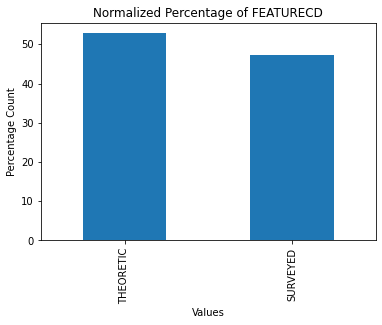

In [141]:
samp_or_at[0].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of FEATURECD")

It does a excellent job as distribution is similar to population

Text(0.5, 1.0, 'Normalized Percentage of QSECT')

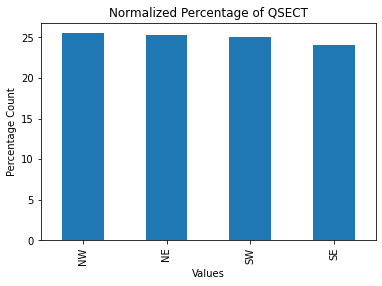

In [143]:
samp_or_at[1].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of QSECT")


it does a good job overally but relatively it is the worst out of the other techniques

Text(0.5, 1.0, 'Normalized Percentage of PMER')

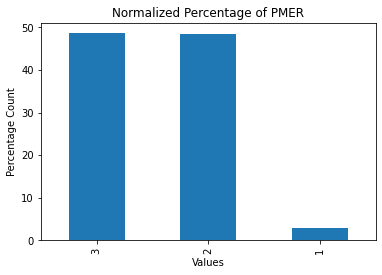

In [144]:
samp_or_at[2].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PMER")

It does a good job since the distribution is similar to population

Text(0.5, 1.0, 'Normalized Percentage of PSECT')

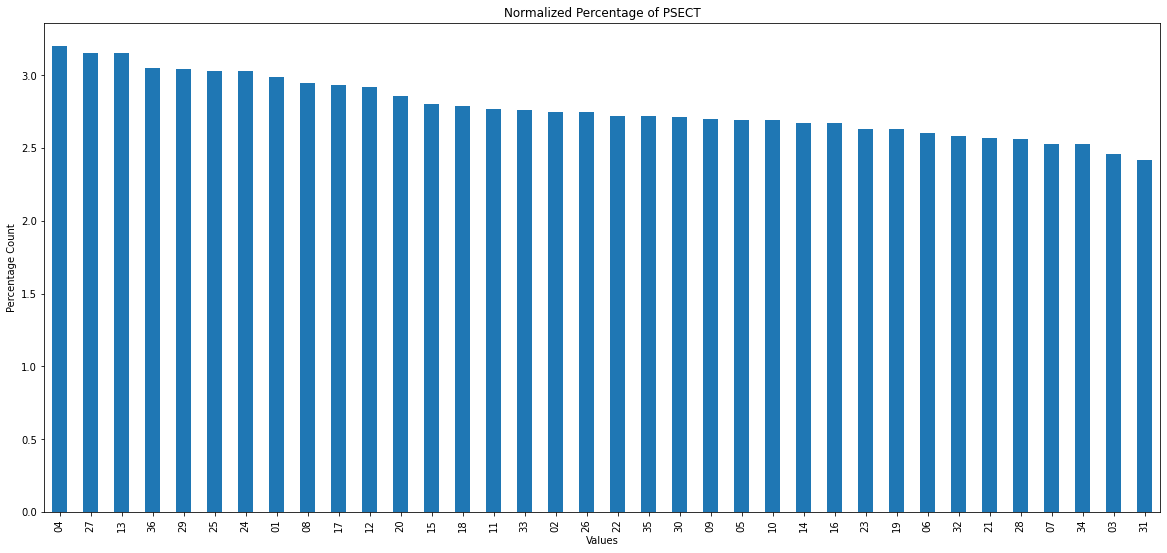

In [147]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_or_at[3].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PSECT")


It does a similar job compared to the sampling techniques for PSECT

Text(0.5, 1.0, 'Normalized Percentage of PTWP')

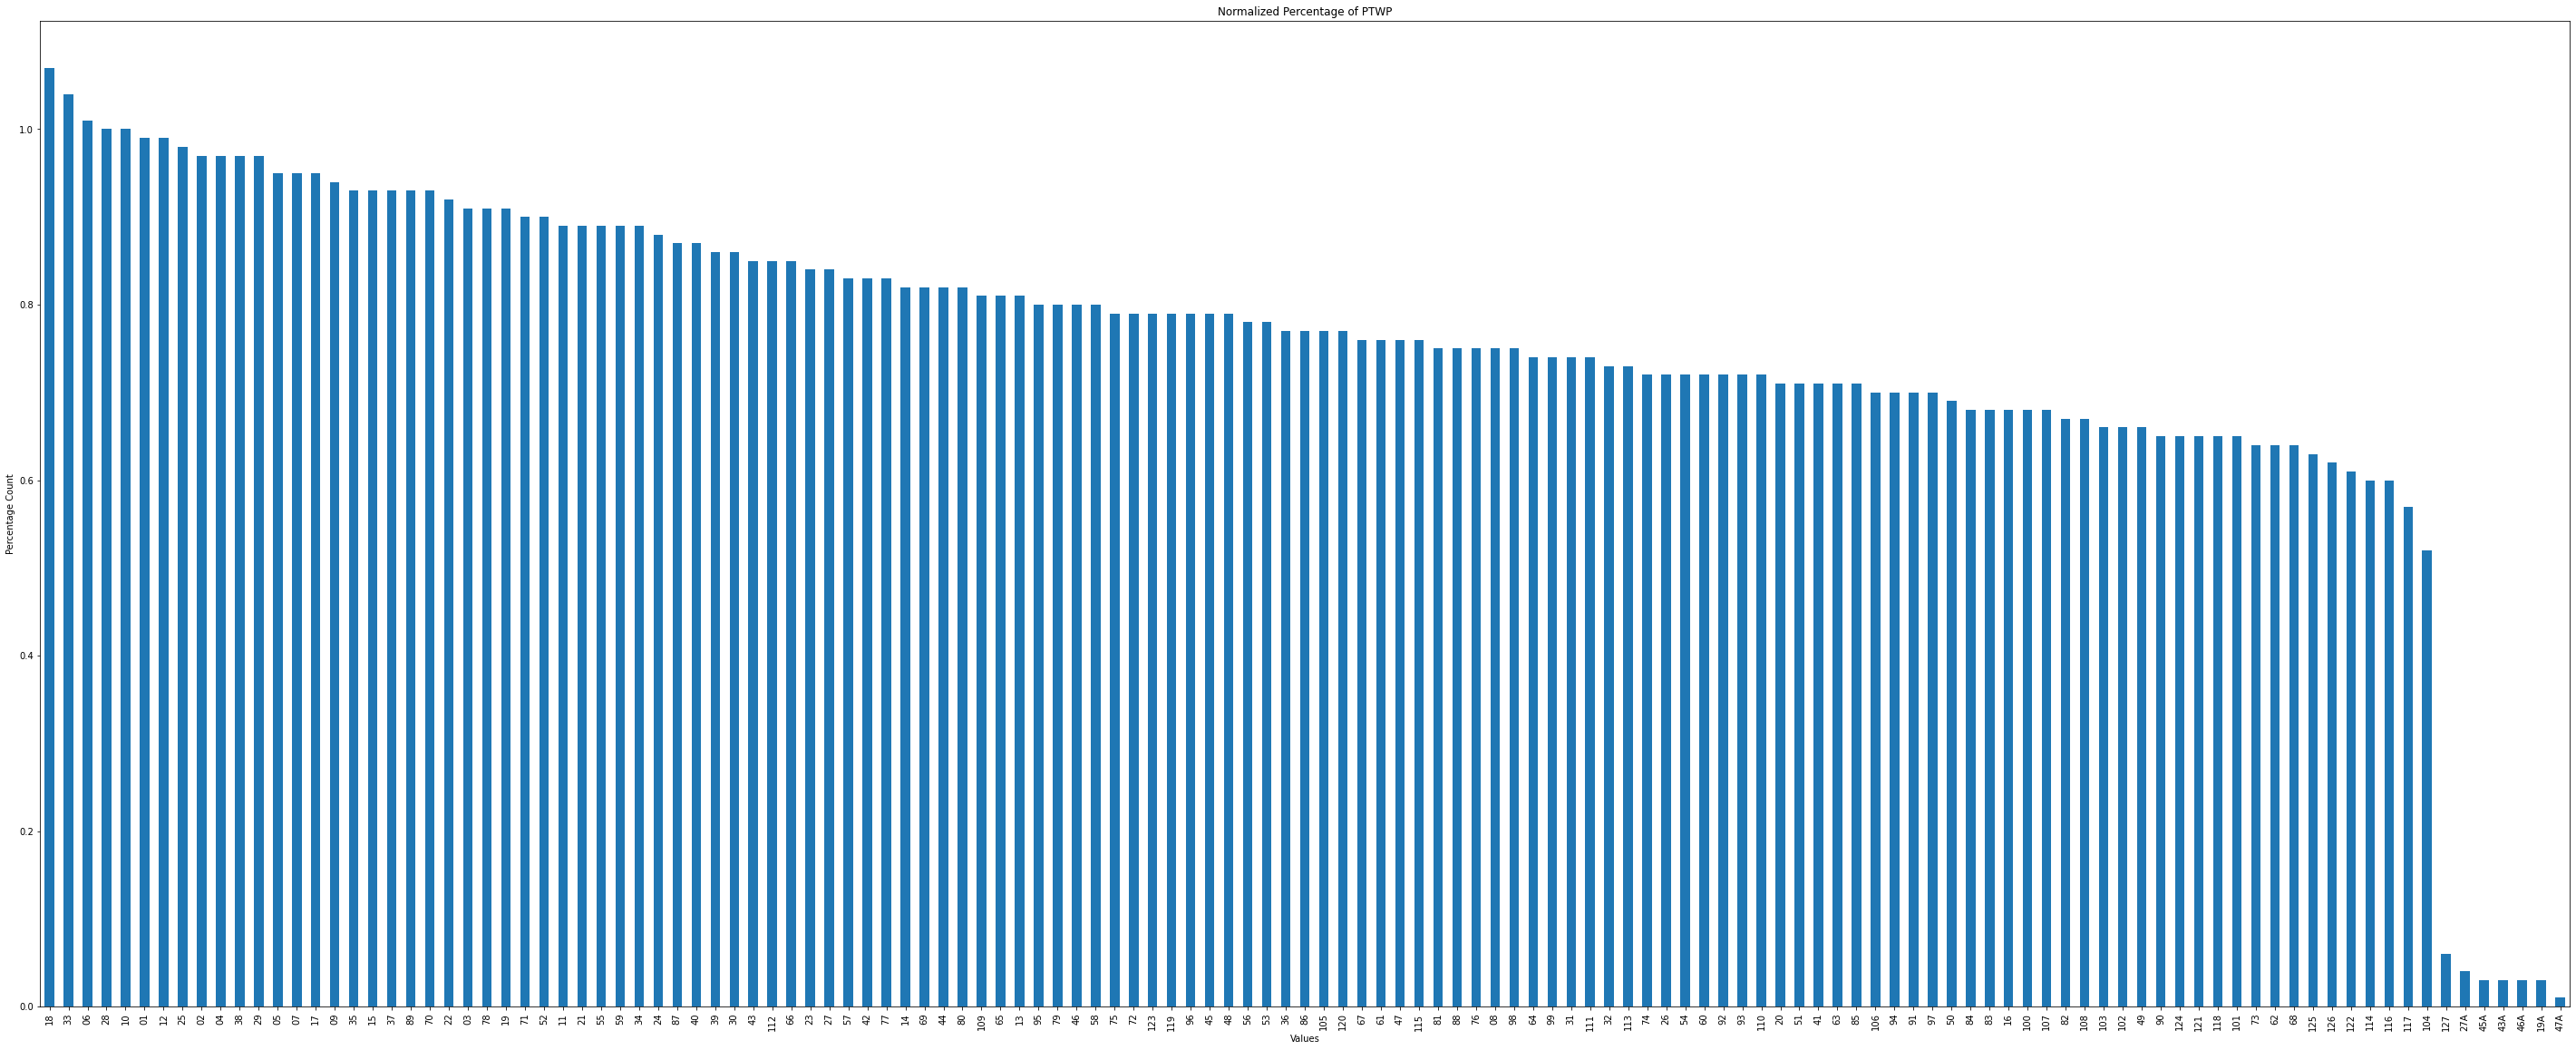

In [148]:
fig, ax = plt.subplots(figsize =(50, 20))
samp_or_at[4].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PTWP")

It does an excellent job since the distribution looks identical to the population

Text(0.5, 1.0, 'Normalized Percentage of PRGE')

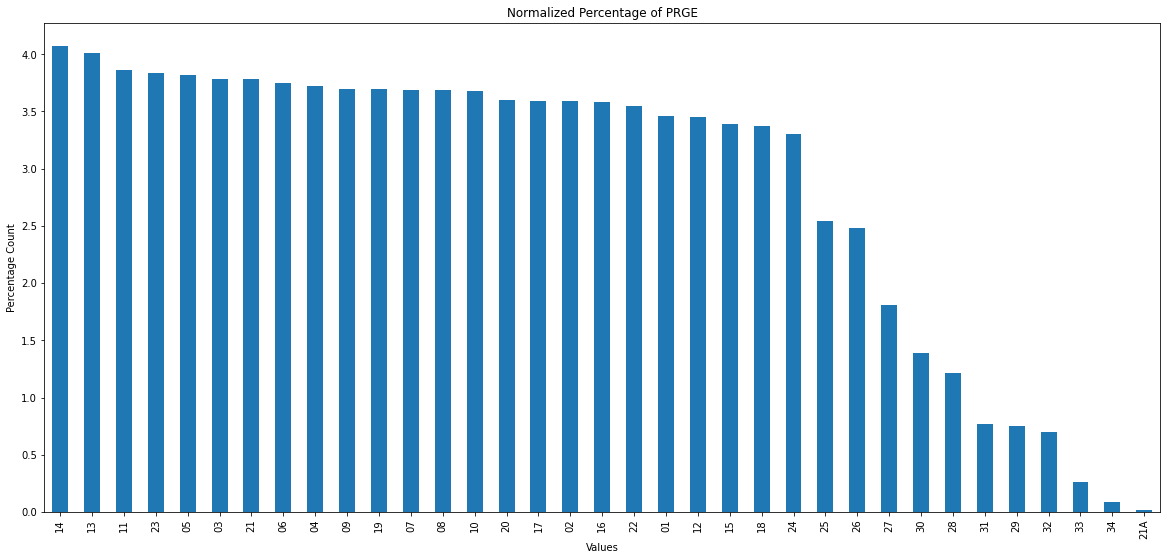

In [149]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_or_at[5].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE")

In [150]:
error_samp_ort=samp_error(pop_at,samp_or_at)

Let us draw bar graphs to see which one did best

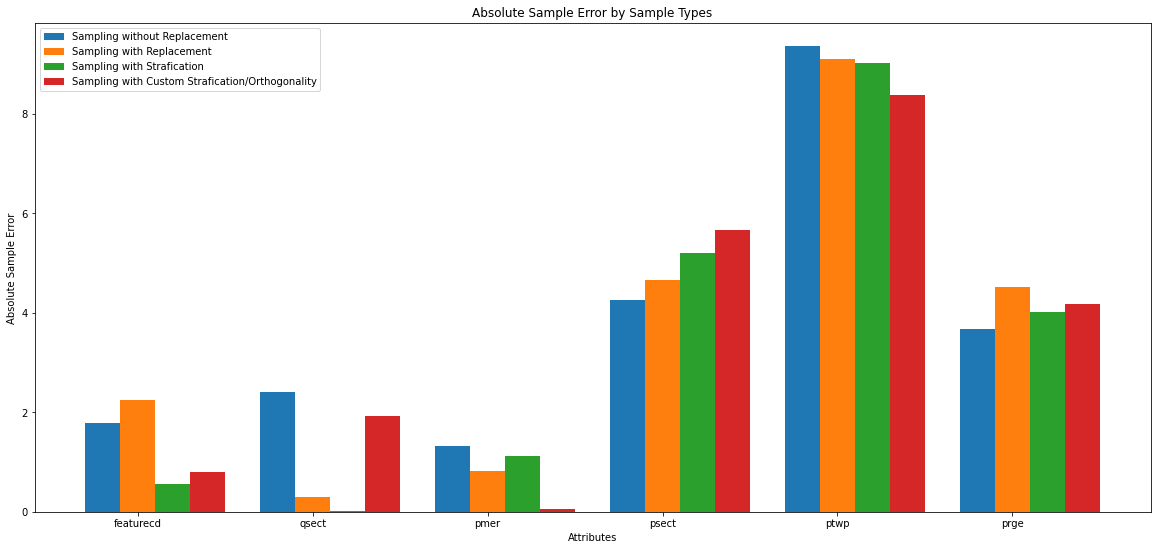

In [151]:
fig, ax = plt.subplots(figsize =(20, 9))
x_val=["featurecd","qsect","pmer","psect","ptwp","prge"]
list_error_samp_nrep=list(error_samp_nrep)
list_error_samp_rep=list(error_samp_rep)
list_error_samp_str=list(samp_error_str)
list_error_samp_ort=list(error_samp_ort)
X_axis=np.arange(len(x_val))

width=0.2

plt.bar(X_axis,list_error_samp_nrep,width,label="Sampling without Replacement")
plt.bar(X_axis+width,list_error_samp_rep,width,label="Sampling with Replacement")
plt.bar(X_axis+width*2,list_error_samp_str,width,label="Sampling with Strafication")
plt.bar(X_axis+width*3,list_error_samp_ort,width,label="Sampling with Custom Strafication/Orthogonality")


plt.xticks(X_axis+width,x_val)
plt.xlabel("Attributes")
plt.ylabel("Absolute Sample Error")
plt.title("Absolute Sample Error by Sample Types")
plt.legend()
plt.show()

Based on the plot, we can conclude that sampling with stratification performed best